Trajectron seems to support providing a map for a scene. This might be a way to get better predictions, that actually stay on the pathways instead of go through buildings. However, by default it supports maps from NuScenes, but not images (even though some traces of that remain in the code.)  More info about support in trajectron is in [issue #14](https://github.com/StanfordASL/Trajectron-plus-plus/issues/14) on their Github.

This notebook is used to test my implementation to add map support to Trajectron.

CHANGELOG:

* 2024-12-27 : Created
    * Draw the map image
    * Training _sometimes_ (randomly?) gives NaN matrixes since using map encoding.
        * Call Image map and test if converted points of all tracks fall within realistic image bounds (e.g. no negative points)
* 2024-12-28: Cells to double check heading
    * Found bug in `config.json`: heading state index was derived from position instead of velocity. (changed [0,1] into [2,3])


In [1]:
from pathlib import Path
from trap.frame_emitter import Camera
from trap.utils import ImageMap
import cv2
import matplotlib.pyplot as plt
import numpy as np

path = Path("EXPERIMENTS/raw/hof3/")
calibration_path = Path("../DATASETS/hof3/calibration.json")
homography_path = Path("../DATASETS/hof3/homography.json")

camera = Camera.from_paths(calibration_path, homography_path, 12)


/home/ruben/suspicion/trap/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_path = Path("../DATASETS/hof3/map-undistorted-H-2.png")
print(image_path, image_path.exists())


../DATASETS/hof3/map-undistorted-H-2.png True


(1440, 2560, 3)
(72, 128, 3)


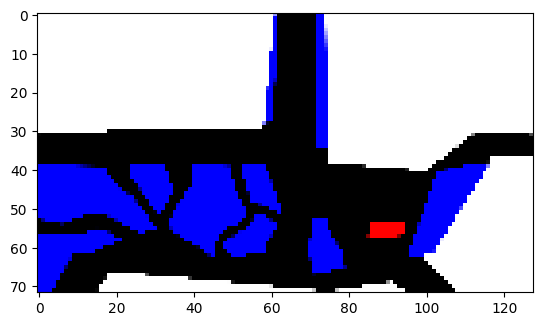

In [3]:
homography_matrix = np.array([
            [5, 0,0],
            [0, 5,0],
            [0,0,1],
        ]) # 100 scale
img = cv2.imread(image_path)
print(img.shape)
img = cv2.resize(img, (img.shape[1]//20, img.shape[0]//20))

print(img.shape)
imgmap = ImageMap(img, homography_matrix, "hof3-undistorted-H-2")
# img = cv2.imread(image_path)



plt.imshow(img)


In [19]:

img = imgmap.as_image()

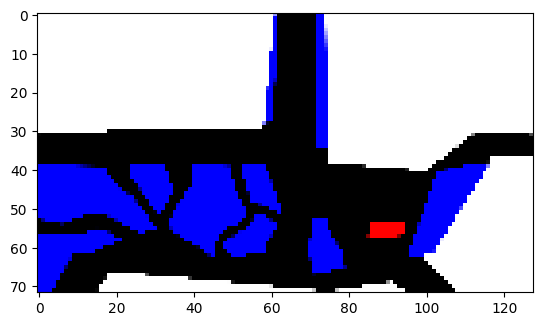

In [25]:

# img = np.flipud(img)
plt.imshow(img)
# plt.gca().invert_yaxis()

In [6]:
from trap.tracker import TrackReader


reader = TrackReader(path, camera.fps, exclude_whitelisted = False, include_blacklisted=False)

In [7]:

from typing import List
from trap.frame_emitter import Track
from trap.tracker import FinalDisplacementFilter


tracks: List[Track] = [t for t in reader]
filter = FinalDisplacementFilter(2)
tracks = filter.apply(tracks, camera)

In [8]:
# track = tracks[0]
for track in tracks:
    history = track.get_projected_history(None, camera)
    points = imgmap.to_map_points(history)
    print(history, points)
    if not ((points[:,0] > 0 ) & (points[:,0] < 2440) & (points[:,1] > 0) & (points[:,1] < 1440)).all():
        print("not all points between limits")
        print(points)
    break

# track.to_trajectron_node(camera, env)

[[     12.247      6.8275]
 [     12.416      6.5942]
 [     12.528      6.5035]
 [     12.594      6.4782]
 [     12.631       6.477]
 [      12.66       6.424]
 [     12.706       6.369]
 [     12.785      6.2094]
 [     12.849      6.0079]
 [     12.919      5.7624]
 [     12.954      5.6717]
 [     12.979      5.6476]
 [     12.985       5.613]
 [     13.027      5.4535]
 [     13.072      5.2315]
 [     13.129       4.995]
 [     13.159       4.894]
 [     13.167      4.8371]
 [     13.163      4.8151]
 [     13.174      4.7545]
 [       13.2      4.5546]
 [     13.237      4.2617]
 [     13.241       4.165]
 [     13.242      4.1164]
 [     13.233      4.1089]
 [     13.238      4.0344]
 [      13.24       3.967]
 [     13.318      3.5567]
 [     13.329      3.4015]
 [     13.344      3.3385]
 [     13.357      3.3064]
 [     13.331      3.3068]
 [     13.298      3.0786]
 [      13.35      2.8114]
 [     13.364      2.6867]
 [     13.346      2.6791]
 [     13.326      2.6335]] 

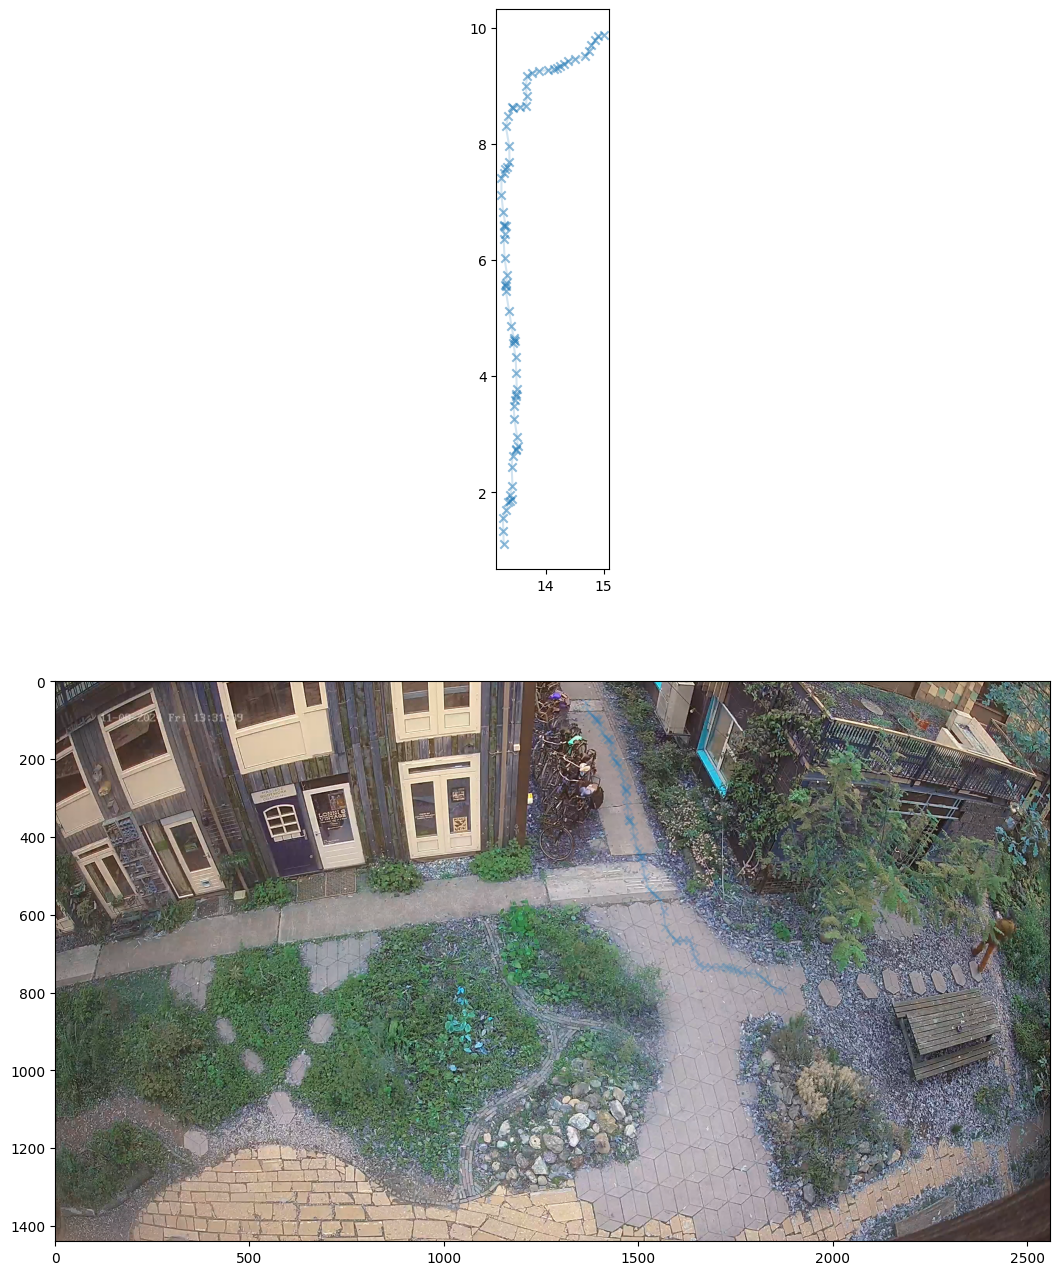

In [9]:
track = tracks[20]
len(track.history)

fig = plt.figure(figsize=(20,16))
ax1, ax2 = fig.subplots(2)

im = cv2.imread("../DATASETS/hof3/output.png")
ax2.imshow(im)
ax1.set_aspect(1)
ax2.set_aspect(1)

t = track.get_with_interpolated_history()
points = t.get_projected_history(None, camera)
x, y = points[:,0], points[:,1]
ax1.plot(x, y, alpha=.2)
ax1.scatter(x, y, marker='x', alpha=.5)




l = [d.get_foot_coords()[0] for d in track.history]
t = [d.get_foot_coords()[1] for d in track.history]
ax2.plot(l, t, alpha=.2)
ax2.scatter(l, t, marker='x', alpha=.2)




## Test cropping of maps
Similar to `get_cropped_maps_from_scene_map_batch()`  as used in `prediction_server.py`.

In [10]:
v = np.diff(points, axis=0)
# this angle formula comes from 
angles = [-np.arctan2(v[i, 0],
                                v[i, 1]) * 180 / np.pi for i in range(v.shape[0])]
angles

[99.17289191829194,
 145.38359542733454,
 145.45747075339742,
 153.38132347369094,
 143.50219249969786,
 107.41324194434551,
 103.18682333877918,
 135.1039011792769,
 119.59945372561799,
 116.7801428815335,
 109.98894043130318,
 99.18912044775988,
 96.7451694797026,
 103.30612625301178,
 123.6212057127049,
 172.02391500189054,
 -176.03717023364996,
 177.03564826765745,
 93.76808809597998,
 91.28307403063258,
 -152.45887910552403,
 151.12995651947134,
 165.28228606465618,
 -170.19503622897125,
 -179.06726071552106,
 155.01689423272055,
 128.5345842544236,
 168.35294787019714,
 154.26131138597705,
 179.88656922722078,
 -174.10210933989364,
 -169.64773317077814,
 77.26207536280874,
 157.18404495447388,
 -175.67544341520608,
 169.4682767805252,
 -177.34318436522642,
 -171.63388387952614,
 172.6662123310602,
 169.51409368947765,
 58.74581501349769,
 -173.0200297904452,
 -170.82651453849562,
 -171.04745749776717,
 -169.06545954403455,
 -166.30394576070668,
 20.9939285462061,
 167.70675733320

In [11]:
points[1:].shape, len(angles)

((71, 2), 71)

In [12]:
import torch
# torch.tensor(imgmap.data)

In [13]:
input_points = points[0:10:1]
input_angles = angles[0:10:1]
input_maps = [imgmap] * input_points.shape[0]
print(input_points.shape, len(input_angles), len(input_maps))

(10, 2) 10 10


In [14]:
cropped_maps = ImageMap.get_cropped_maps_from_scene_map_batch(input_maps, input_points, [50, 10, 50, 90], input_angles)

/home/ruben/suspicion/trap/.venv/lib/python3.10/site-packages/trajectron/environment/map.py:121: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  centers = torch.tensor([s_map.to_map_points(scene_pts[np.newaxis, i]) for i, s_map in enumerate(maps)],
/home/ruben/suspicion/trap/.venv/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [15]:
# cropped_maps.all()

**I still cheat a little bit by drawing the reverse angle, as this is used by trajectron as the map should turn the opposite direction towards the angle** TODO: make sure these maths line up with prediction server and `process data`

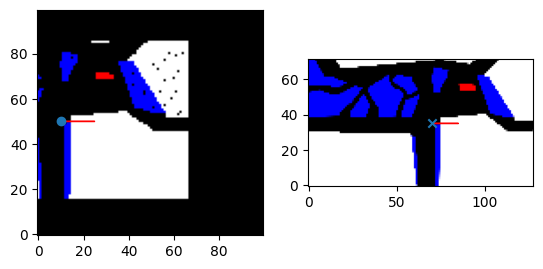

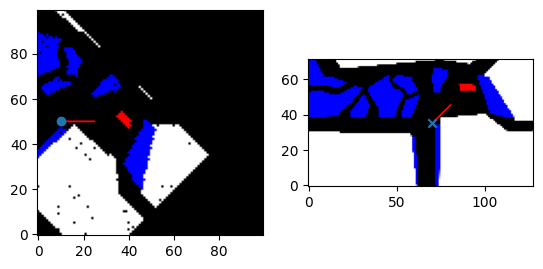

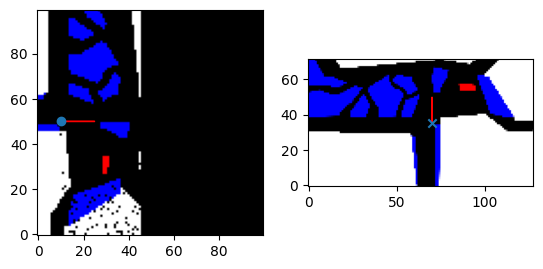

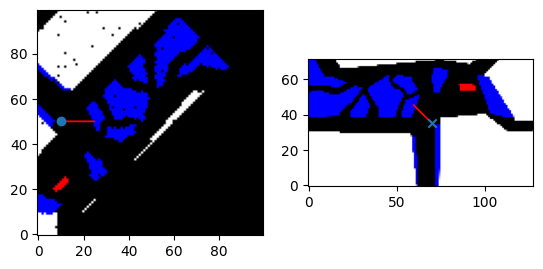

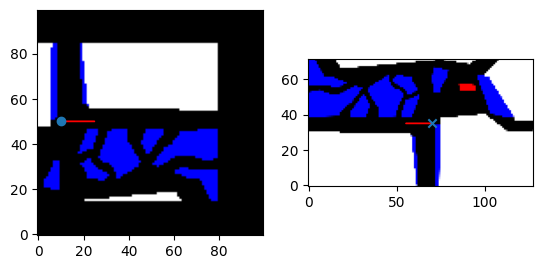

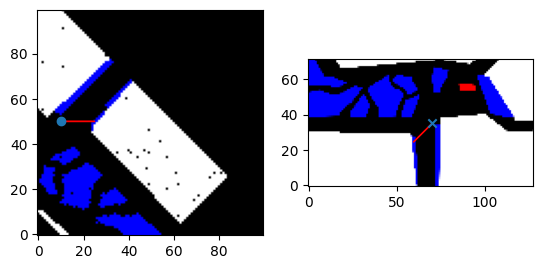

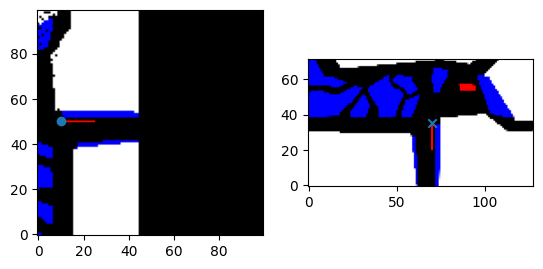

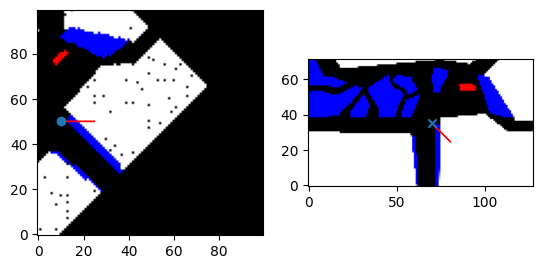

In [34]:
def print_maps(cropped_maps, angles, input_points, previous_points = None):
    if previous_points is None:
        previous_points = [None] * len(cropped_maps)
    for i, (m, angle, input_point, previous_point) in enumerate(zip(cropped_maps, angles, input_points, previous_points)):
        fig, (ax1, ax2) = plt.subplots(1,2)
        ax1.imshow(np.transpose(m.cpu().numpy(), (2, 1, 0)).astype(np.uint)*255)
        ax1.arrow(10, 50, 15, 0, color='r')
        ax1.scatter([10], [50], marker='o')

        ax1.invert_yaxis()
        # plt.show()
        ax2.imshow(imgmap.as_image())
        point = imgmap.to_map_points(np.array([input_point]))
        
        # print(p)
        
        # if len(input_points) > i+1:
        y = np.sin(np.deg2rad(-angle))
        x = np.cos(np.deg2rad(-angle))
        d = np.array([x,y]) * 15
        # dxy = (input_points[i+1] - input_points[i])
        # d = (dxy / np.linalg.norm(dxy)) * 15
        # # print(p[0][0], p[0][1],d[0], d[1])
        ax2.arrow(point[0][0], point[0][1],d[0], d[1], color='r')
        ax2.scatter(point[0][0], point[0][1], marker='x')

        if previous_point is not None:
            prevp = imgmap.to_map_points(np.array([previous_point]))
            ax2.arrow(prevp[0][0], prevp[0][1],d[0], d[1], color='r')
            ax2.scatter(prevp[0][0], prevp[0][1], marker='x')

        ax2.invert_yaxis()
        plt.show()
print_maps(cropped_maps, input_angles, input_points)

Test with only rotation, from a fixed point

[-0.0, -45.0, -90.0, -135.0, -180.0, 135.0, 90.0, 45.0]


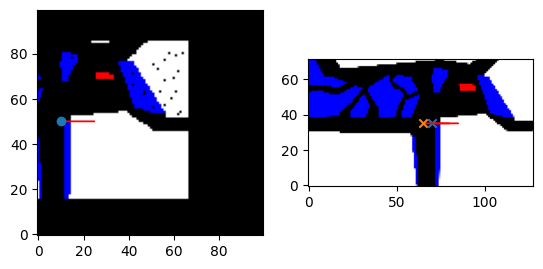

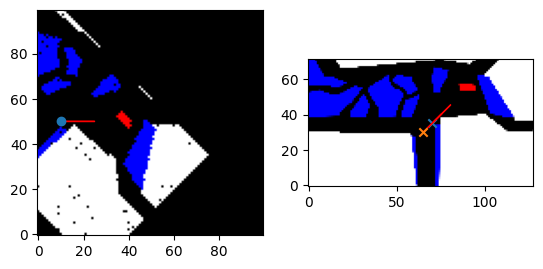

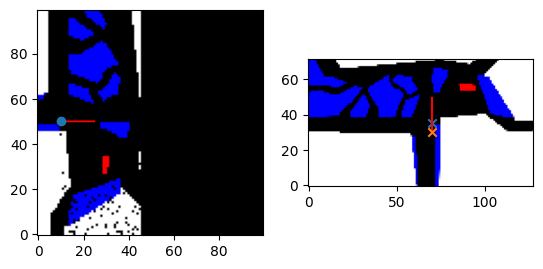

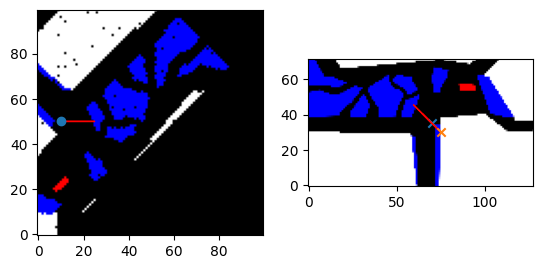

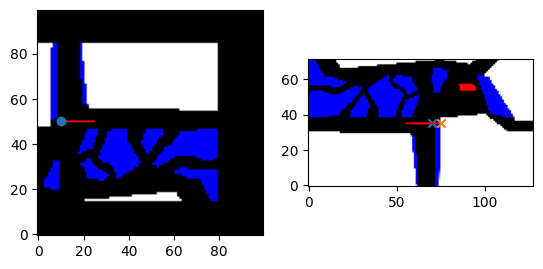

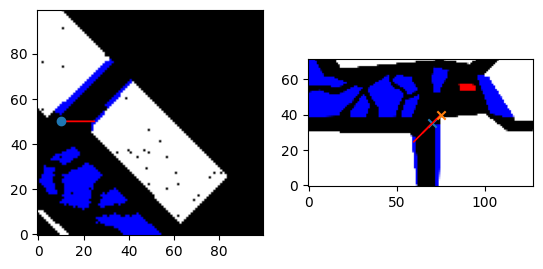

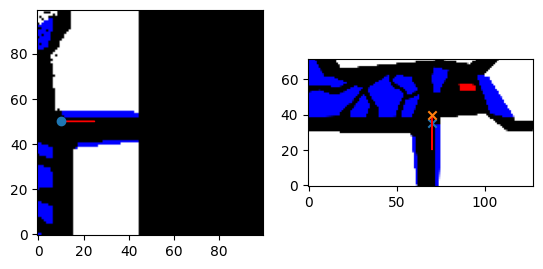

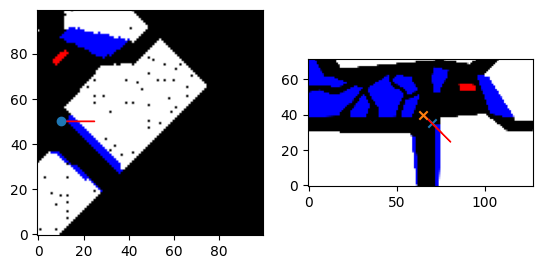

In [35]:
input_points = np.array([[14,7]]* 8)
previous_points_offset = np.array([
    [-1, 0],
    [-1, -1],
    [0, -1],
    [1, -1],
    [1, 0],
    [1, 1],
    [0, 1],
    [-1, 1],
])
previous_points = input_points + previous_points_offset

input_angles = [
    -np.arctan2(i[1]-p[1],
                                            i[0]-p[0]) * 180 / np.pi
                for i,p in zip(input_points, previous_points)]
print(input_angles)
# input_angles = list(range(0,360, 45))
input_maps = [imgmap] * 8

cropped_maps = ImageMap.get_cropped_maps_from_scene_map_batch(input_maps, input_points, [50, 10, 50, 90], input_angles)
print_maps(cropped_maps, input_angles, input_points, previous_points)